In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Feb 12 02:38:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    25W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
import numpy as np
import pickle
from os import listdir
import cv2

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from sklearn.utils import class_weight

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten

from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
import os 
from random import shuffle

# Loading the Data

In [4]:
from tqdm import tqdm
from time import sleep

In [5]:
import numpy as np
import pandas as pd  
import os 
from sklearn.datasets import load_files

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
data_dir =  '/content/drive/MyDrive/scraped_images1'
data = load_files(data_dir)

# Data Preprocessing and exploring

In [8]:
folders=os.listdir('/content/drive/MyDrive/scraped_images1')
print(folders)

['Bottle gourd fruit real', 'Agasta White', 'Aloe', 'Alstonia scholaris flower real', 'Celery leaf real', 'Amaranth leaf real', 'Butterfly pea', 'Cabbage leaf real', 'Centella asiatica leaf real', 'Cha-om', 'Coccinia grandis', 'Common beet root real', 'Cissus quadrangularis', 'Culantro leaf real', 'Chauya', 'Cucumber fruit real', 'fahthalinejol', 'Garlic', 'Esldpagpon', 'Ginger root real', 'Pandan leaves real', 'Lemongrass tree real', 'Moringa sheath real', 'Lemon basil leaf real', 'Piper nigrum fruit real', 'mulberry', 'Makham', 'Ginseng root real', 'Greater galangal root real', 'Kai Lan leaf real', 'Sugar cane trunk real', 'Turmeric root real', 'Rambutan fruit real', 'Tinospora crispa', 'Stevia leaf real', 'Sweet peas', 'Punica granatum fruit real', 'Sesbania javanica Miq flower real', 'Shallot', 'Siamese senna flower real', 'Watermelon fruit real']


In [9]:
X = np.array(data['filenames'])
y = np.array(data['target'])
labels = np.array(data['target_names'])

print('Data files - ',X)
print('Target labels - ',y)

Data files -  ['/content/drive/MyDrive/scraped_images1/Pandan leaves real/hori_CIMG3922.JPG'
 '/content/drive/MyDrive/scraped_images1/Coccinia grandis/b1_20230128_135905.jpg'
 '/content/drive/MyDrive/scraped_images1/Cucumber fruit real/c1_19.jpg'
 ...
 '/content/drive/MyDrive/scraped_images1/Common beet root real/deg90_44.jpg'
 '/content/drive/MyDrive/scraped_images1/Greater galangal root real/vert_7.jpg'
 '/content/drive/MyDrive/scraped_images1/Kai Lan leaf real/hori_6.jpg']
Target labels -  [26 12 14 ... 13 20 21]


# Load the images

In [15]:
import keras

In [25]:
from tensorflow.keras.utils import load_img

In [26]:
def convert_img_to_arr(file_path_list):
    arr = []
    img_width, img_height = 128,128
    for file_path in file_path_list:
        img = load_img(file_path, target_size = (img_width, img_height))
        img = img_to_array(img)
        arr.append(img)
        
    return arr
 
X = np.array(convert_img_to_arr(X))
print(X.shape)
print(y.shape)

(5491, 128, 128, 3)
(5491,)


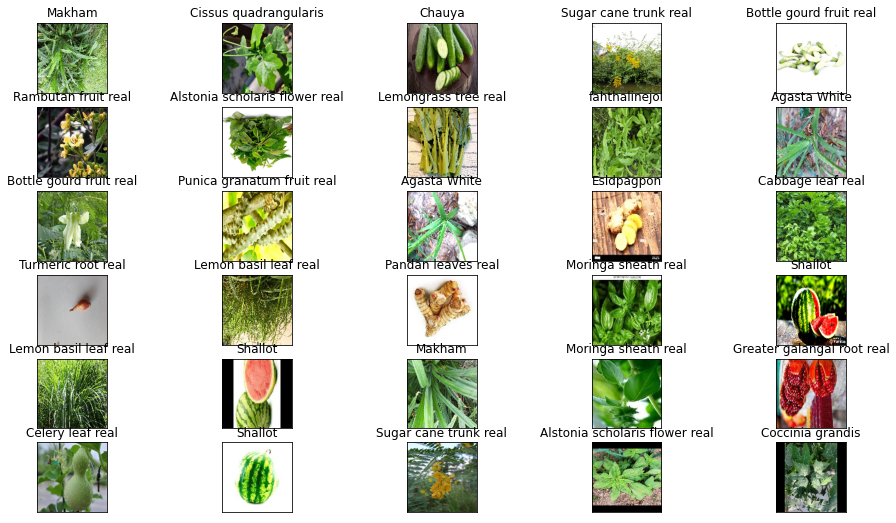

In [27]:
import matplotlib.pyplot as plt
 
fig = plt.figure(figsize = (16,9))
for i in range(10):
    ax = fig.add_subplot(1,10,i+1,xticks=[],yticks=[])
    ax.imshow((X[i].astype(np.uint8)))
    plt.title(folders[y[i]])

In [28]:
X = X.astype('float32')/255
no_of_classes = len(np.unique(y))
no_of_classes

41

In [29]:
y

array([26, 12, 14, ..., 13, 20, 21])

# converts a class vector (integers) to binary class matrix

In [30]:
from keras.utils import np_utils
y = np.array(np_utils.to_categorical(y,no_of_classes))
y[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [31]:
 #80% train, 10% validation, and 10% test.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,train_size=0.7,shuffle=True)

X_test, X_valid, y_test, y_valid = train_test_split(X_test,y_test, test_size = 0.5)

In [32]:
print('The train Data Shape ', X_train.shape[1:])

The train Data Shape  (128, 128, 3)


# Model

In [33]:
base_model =tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False,input_shape=(128,128,3))

9406464/9406464 [==============================] - 0s 0us/step


In [34]:
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][

In [35]:
base_model.trainable = False

# Add head 

In [36]:
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
prediction_layer = tf.keras.layers.Dense(units=no_of_classes,activation='softmax')(average_pooling_layer)

In [37]:
model = tf.keras.models.Model(inputs=base_model.input, outputs=prediction_layer)

In [38]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']           

# train model

In [56]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), loss="categorical_crossentropy",metrics=["accuracy"])

In [57]:
history = model.fit(X_train,y_train,epochs=1000,validation_data=(X_valid,y_valid),batch_size=128)

Epoch 1/1000
31/31 [==============================] - 12s 141ms/step - loss: 5.4058e-04 - accuracy: 0.9997 - val_loss: 0.1725 - val_accuracy: 0.9697
Epoch 2/1000
31/31 [==============================] - 3s 105ms/step - loss: 0.0031 - accuracy: 0.9995 - val_loss: 0.1606 - val_accuracy: 0.9697
Epoch 3/1000
31/31 [==============================] - 3s 104ms/step - loss: 0.0015 - accuracy: 0.9997 - val_loss: 0.1048 - val_accuracy: 0.9818
Epoch 4/1000
31/31 [==============================] - 3s 106ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 0.2554 - val_accuracy: 0.9624
Epoch 5/1000
31/31 [==============================] - 3s 105ms/step - loss: 0.0021 - accuracy: 0.9997 - val_loss: 0.1617 - val_accuracy: 0.9745
Epoch 6/1000
31/31 [==============================] - 3s 105ms/step - loss: 0.0029 - accuracy: 0.9997 - val_loss: 0.1494 - val_accuracy: 0.9769
Epoch 7/1000
31/31 [==============================] - 3s 104ms/step - loss: 0.0029 - accuracy: 0.9995 - val_loss: 0.1700 - val_accu

In [58]:
(eval_loss, eval_accuracy) = model.evaluate(X_test, y_test, batch_size= 128, verbose=2)
print("Accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("Loss: {}".format(eval_loss))

7/7 - 0s - loss: 0.0709 - accuracy: 0.9830 - 363ms/epoch - 52ms/step
Accuracy: 98.30%
Loss: 0.0709456205368042


In [60]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model_MobileNetV2_1", 'wb') as f:
  f.write(tflite_model)

# Acuuracy and Loss graphs

26/26 [==============================] - 1s 16ms/step


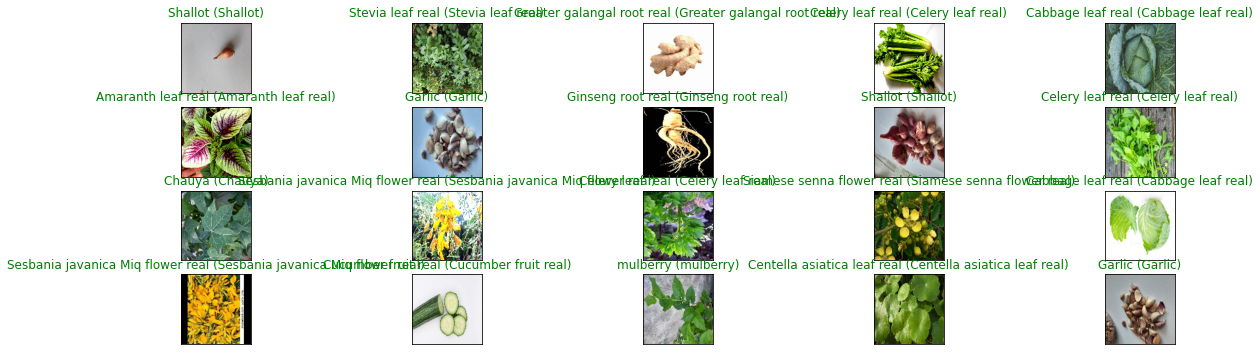

In [61]:
def visualize_pred(y_pred):
    fig = plt.figure(figsize=(20, 9))
    for i, idx in enumerate(np.random.choice(X_test.shape[0], size=20, replace=False)):
        ax = fig.add_subplot(6, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(X_test[idx]))
        pred_idx = np.argmax(y_pred[idx])
        true_idx = np.argmax(y_test[idx])
        ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

visualize_pred(model.predict(X_test))

26/26 [==============================] - 1s 19ms/step


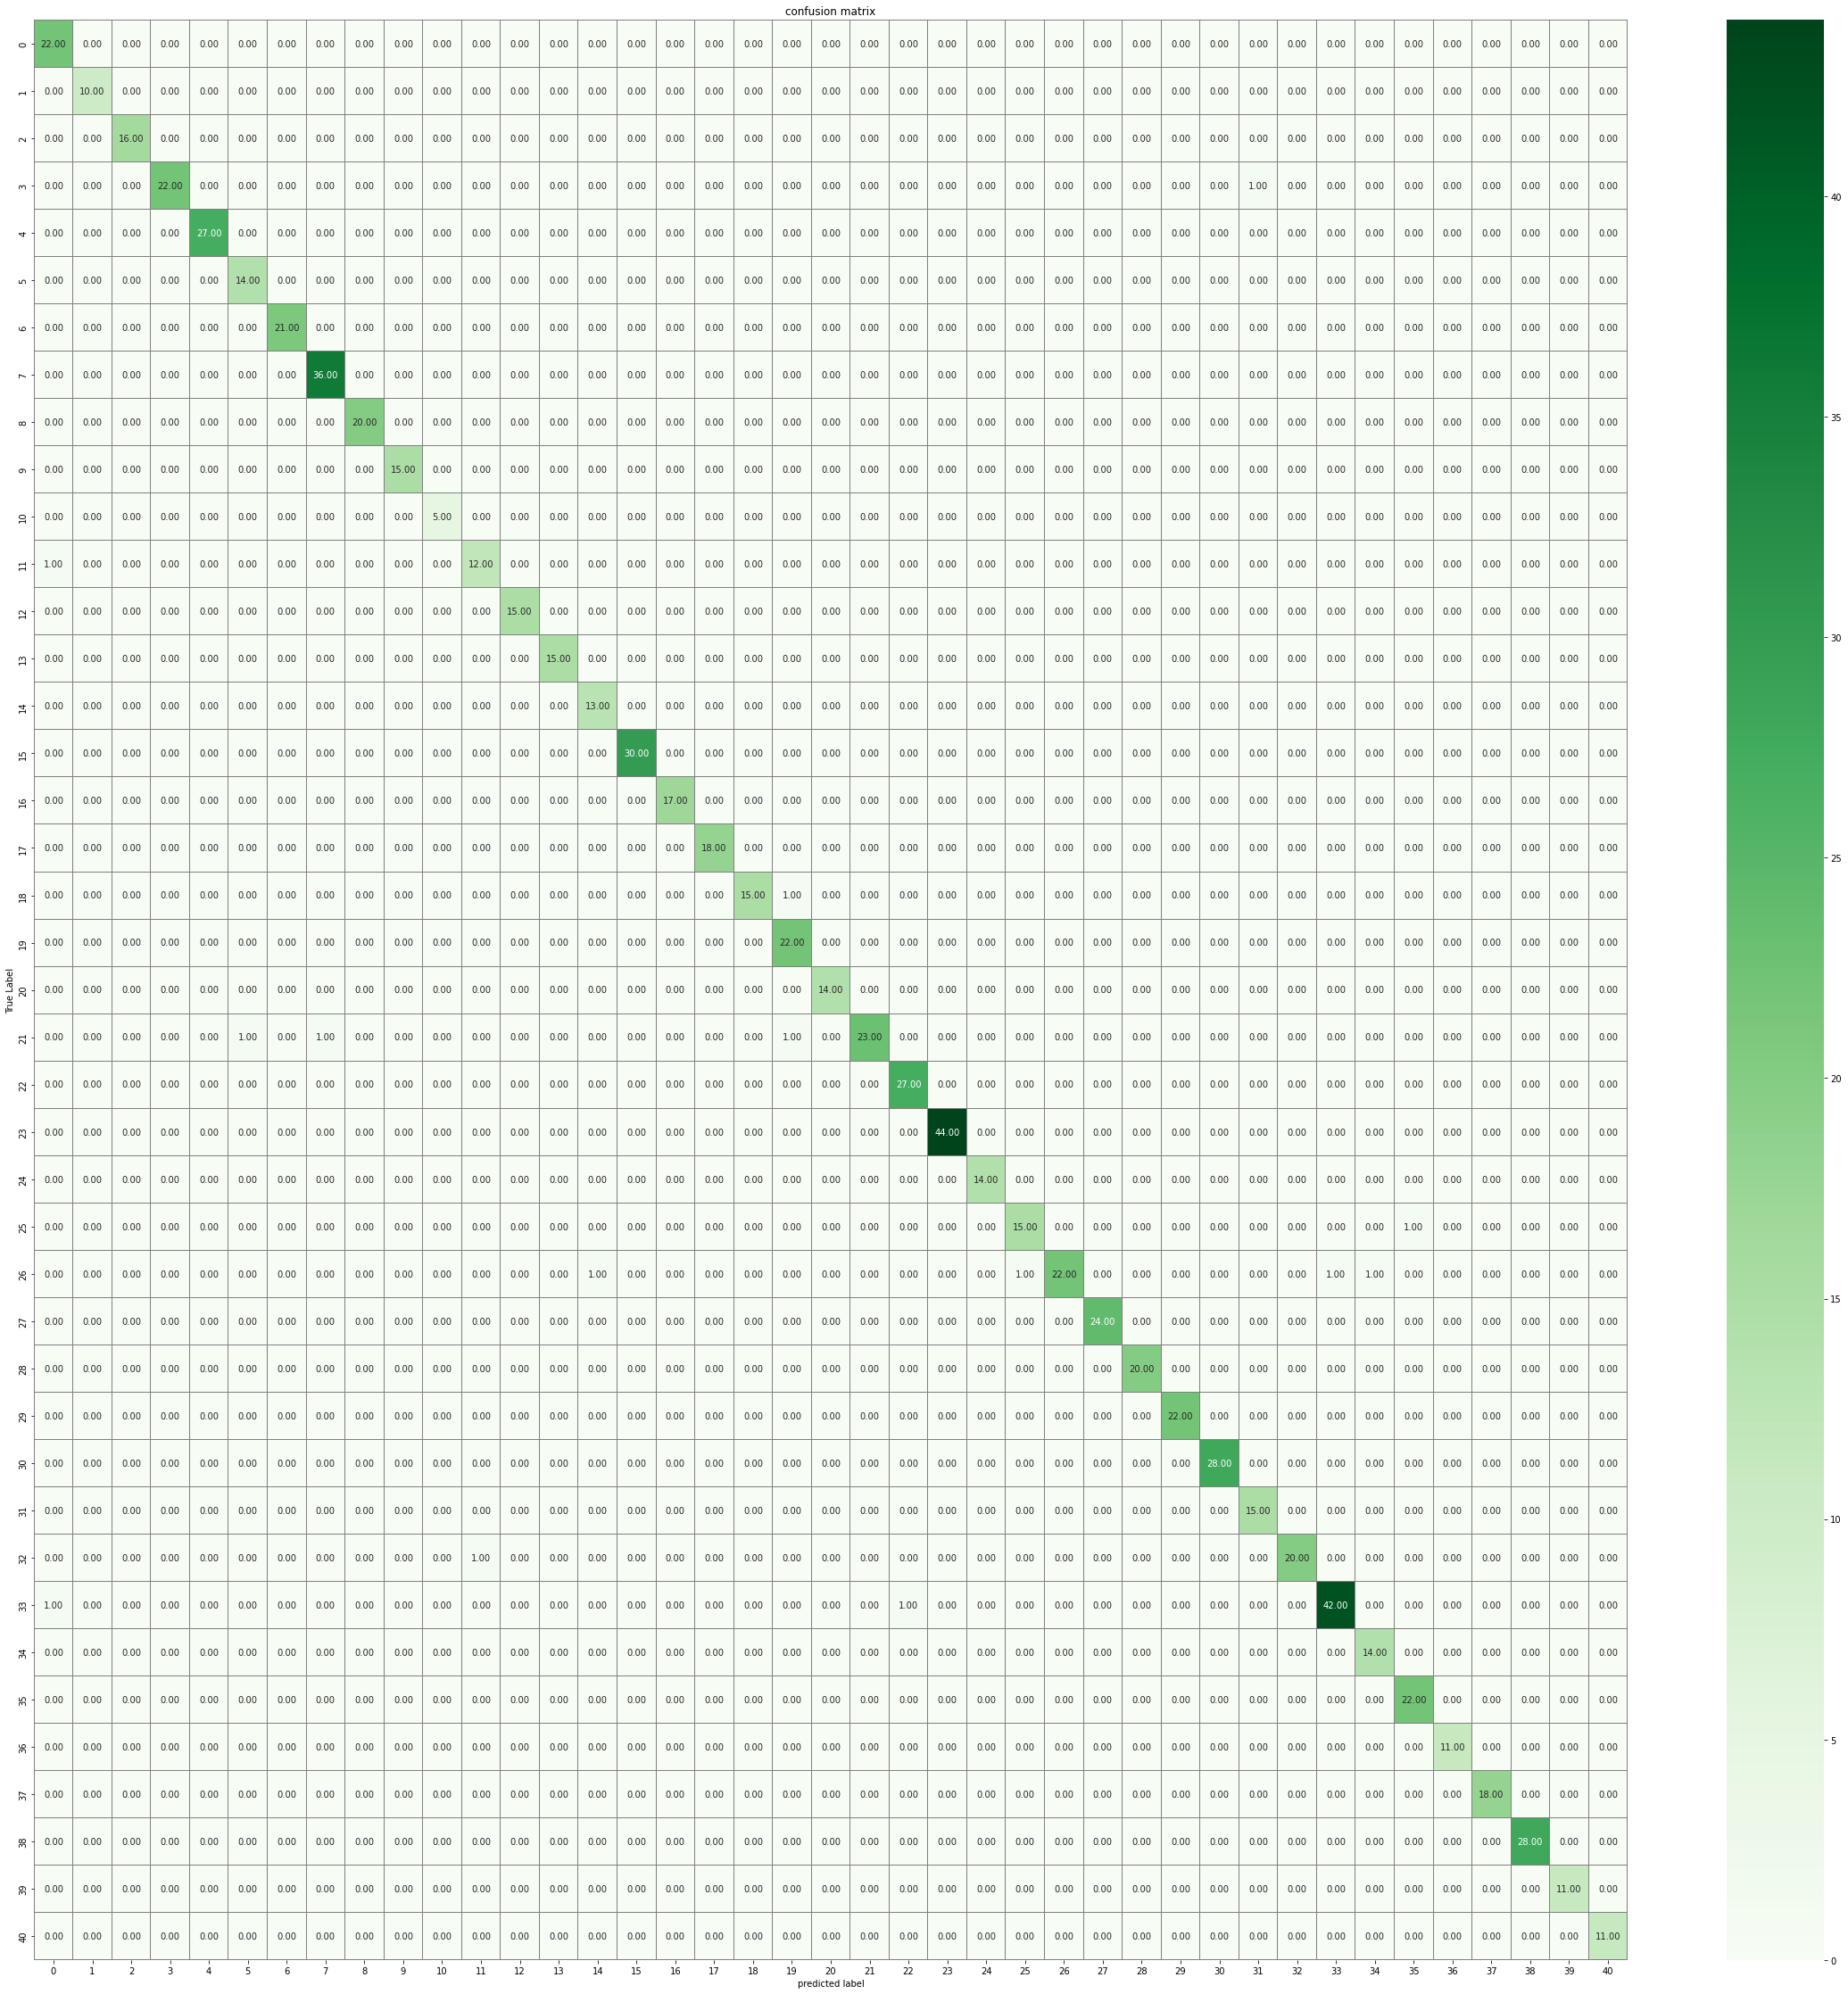

In [63]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(y_test,axis = 1)
confusion_mtx = confusion_matrix(Y_true,Y_pred_classes)
f,ax = plt.subplots(figsize = (40,40))
sns.heatmap(confusion_mtx,annot=True,linewidths = 0.01,cmap="Greens",
            linecolor = "gray",fmt = ".2f",ax=ax
            )
plt.xlabel("predicted label")
plt.ylabel("True Label")
plt.title("confusion matrix")
plt.show()

In [64]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [65]:
len(model.layers)

156

In [66]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(y_test,axis = 1)
print("*******************Confusion matrix*******************")
print(confusion_matrix(Y_true,Y_pred_classes))
print("\n*******************Classification report*******************")
print(classification_report(Y_true,Y_pred_classes))

26/26 [==============================] - 0s 17ms/step
*******************Confusion matrix*******************
[[22  0  0 ...  0  0  0]
 [ 0 10  0 ...  0  0  0]
 [ 0  0 16 ...  0  0  0]
 ...
 [ 0  0  0 ... 28  0  0]
 [ 0  0  0 ...  0 11  0]
 [ 0  0  0 ...  0  0 11]]

*******************Classification report*******************
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        22
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        16
           3       1.00      0.96      0.98        23
           4       1.00      1.00      1.00        27
           5       0.93      1.00      0.97        14
           6       1.00      1.00      1.00        21
           7       0.97      1.00      0.99        36
           8       1.00      1.00      1.00        20
           9       1.00      1.00      1.00        15
          10       1.00      1.00      1.00         5
          11       0.92  

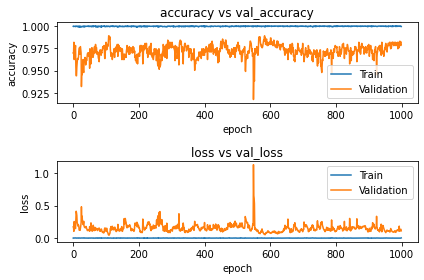

In [67]:
import matplotlib.pyplot as plt 
def plot(history):
    plt.figure(1)
 
    plt.subplot(211)  
    plt.plot(history.history['accuracy'])  
    plt.plot(history.history['val_accuracy'])  
    plt.title('accuracy vs val_accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('epoch')  
    plt.legend(['Train', 'Validation'], loc='lower right')  
 
    plt.subplot(212)  
    plt.plot(history.history['loss'])  
    plt.plot(history.history['val_loss'])  
    plt.title('loss vs val_loss')  
    plt.ylabel('loss')  
    plt.xlabel('epoch')  
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.tight_layout()
    plt.show()
 
plot(history)

# Fine-tuning

In [68]:
len(base_model.layers)

154

In [69]:
base_model.trainable = True

In [70]:
for layer in base_model.layers[:100]:
  layer.trainable = False

In [71]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), loss="categorical_crossentropy",metrics=["accuracy"])

In [72]:
history = model.fit(X_train,y_train,epochs=1000,validation_data=(X_valid,y_valid),batch_size=128)

Epoch 1/1000
31/31 [==============================] - 12s 143ms/step - loss: 7.1197e-05 - accuracy: 1.0000 - val_loss: 0.1109 - val_accuracy: 0.9806
Epoch 2/1000
31/31 [==============================] - 3s 104ms/step - loss: 8.1646e-04 - accuracy: 0.9997 - val_loss: 0.1151 - val_accuracy: 0.9769
Epoch 3/1000
31/31 [==============================] - 3s 105ms/step - loss: 0.0010 - accuracy: 0.9997 - val_loss: 0.0978 - val_accuracy: 0.9830
Epoch 4/1000
31/31 [==============================] - 3s 106ms/step - loss: 0.0015 - accuracy: 0.9997 - val_loss: 0.0993 - val_accuracy: 0.9818
Epoch 5/1000
31/31 [==============================] - 3s 106ms/step - loss: 4.4091e-04 - accuracy: 0.9997 - val_loss: 0.0968 - val_accuracy: 0.9806
Epoch 6/1000
31/31 [==============================] - 4s 115ms/step - loss: 2.3923e-04 - accuracy: 1.0000 - val_loss: 0.0912 - val_accuracy: 0.9830
Epoch 7/1000
31/31 [==============================] - 3s 107ms/step - loss: 4.3681e-04 - accuracy: 1.0000 - val_loss: 0

In [73]:
(eval_loss, eval_accuracy) = model.evaluate(X_test, y_test, batch_size= 128, verbose=2)
print("Accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("Loss: {}".format(eval_loss))

7/7 - 0s - loss: 0.0711 - accuracy: 0.9879 - 359ms/epoch - 51ms/step
Accuracy: 98.79%
Loss: 0.07107213139533997


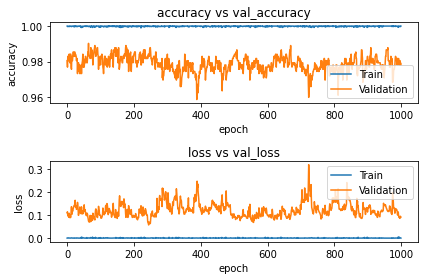

In [74]:
import matplotlib.pyplot as plt 
def plot(history):
    plt.figure(1)
 
    plt.subplot(211)  
    plt.plot(history.history['accuracy'])  
    plt.plot(history.history['val_accuracy'])  
    plt.title('accuracy vs val_accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('epoch')  
    plt.legend(['Train', 'Validation'], loc='lower right')  
 
    plt.subplot(212)  
    plt.plot(history.history['loss'])  
    plt.plot(history.history['val_loss'])  
    plt.title('loss vs val_loss')  
    plt.ylabel('loss')  
    plt.xlabel('epoch')  
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.tight_layout()
    plt.show()
 
plot(history)

In [75]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model_MobileNetV2_2.tflite", 'wb') as f:
  f.write(tflite_model)